/var/folders/tw/j68gkt955z57h83crjdjjrg80000gr/T/ipykernel_8476/980913335.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels, cmap=matplotlib.cm.get_cmap('RdYlBu'))


(-0.9999999505367361, 1.0000000398687234)

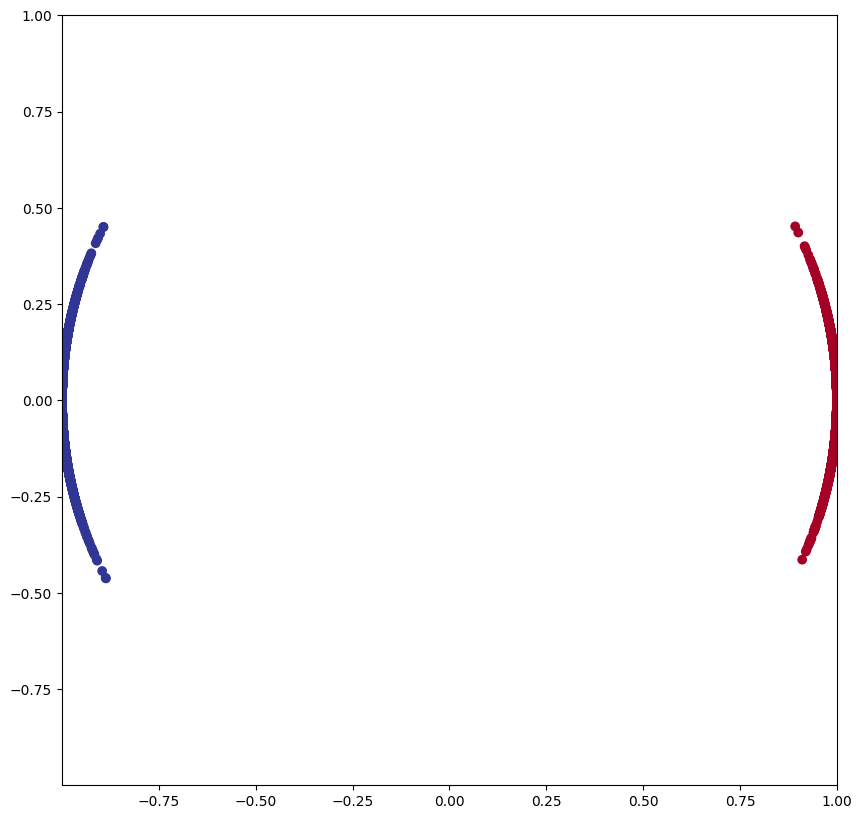

In [1]:
import os, sys, numpy, torch, matplotlib.pyplot, matplotlib.cm

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from settings.noisy_xor import get_dataloader
from utils.optimization import initialize

experiment = {
    'seed': 1234,
    'dataset': 'linear',
    'input_dimension': 2, 
    'sample_size': 5000,  
    'batch_size': 100, 
    'within_cluster_variance': 1. / 50.,
    'clusters_per_class': 1, 
    'epochs': int(2 * 10e5),
    'learning_rate': 0.002,
    'initial_hidden_units': 50,
    'initialization_variance': 10e-6,
    'bias': True,
    'balanced_initialization': True,
    'normalize_inputs': True
}

device, generator = initialize(experiment['seed'])
train_data, rotation_matrix = get_dataloader(**experiment, generator=generator)
test_data = get_dataloader(**experiment, rotation_matrix=rotation_matrix, generator=generator)
inputs = []; labels = []
for batch_inputs, batch_labels in train_data: inputs.append(batch_inputs); labels.append(batch_labels)
inputs, labels = torch.concatenate(inputs), torch.concatenate(labels)

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels, cmap=matplotlib.cm.get_cmap('RdYlBu'))
ax.set_xlim(inputs_[:, 0].min(), inputs_[:, 0].max())
ax.set_ylim(inputs_[:, 0].min(), inputs_[:, 0].max())

In [2]:
import ipycanvas

training_canvas, gradients_norms_canvas, input_domain_canvas = ipycanvas.Canvas(), ipycanvas.Canvas(), ipycanvas.Canvas()
training_canvas.width, training_canvas.height = 1200, 600
gradients_norms_canvas.width = 1200; gradients_norms_canvas.height = 600
input_domain_canvas.width = input_domain_canvas.height = 800
training_canvas.font = gradients_norms_canvas.font = input_domain_canvas.font = "30px arial"
args = ('Results will appear as processed', training_canvas.width / 4, training_canvas.height / 3)
training_canvas.fill_text(*args); gradients_norms_canvas.fill_text(*args); input_domain_canvas.fill_text(*args)

In [3]:
training_canvas

Canvas(height=600, width=1200)

In [4]:
gradients_norms_canvas

Canvas(height=600, width=1200)

In [5]:
input_domain_canvas

Canvas(height=800, width=800)

In [6]:
from functools import partial
from plots import plot_train_loss_and_accuracy, plot_weights_and_biases_gradient_norms, plot_samples_activation_hyperplanes
from growing_fully_connected_neural_network import GrowingFullyConnectedNeuralNetwork
from experiment import execute_experiment

plot_train_loss_and_accuracy = partial(plot_train_loss_and_accuracy, canvas=training_canvas)
plot_weights_and_biases_gradient_norms = partial(plot_weights_and_biases_gradient_norms, canvas=gradients_norms_canvas)
plot_samples_activation_hyperplanes = partial(plot_samples_activation_hyperplanes, canvas=input_domain_canvas, 
                                              rotation_matrix=rotation_matrix, dataloader=train_data)

def model_summary(model, model_metrics, epoch, *args, **kwargs):
    for layer_index, layer in enumerate(model.layers):
        model_metrics.append({'epoch': epoch, 'layer': layer_index, 
                                 'neurons_weights_norm': layer.weight.norm(dim=0).detach.cpu().tolist()})
        
    model_metrics.append({'epoch': epoch, 'layer': 'output', 
                             'neurons_weights_norm': model.output_layer.weight.abs().detach.cpu().tolist()})

execute_experiment(
    **experiment,
    experiment_name_parameters=['seed'],
    train_data=train_data, 
    test_data=test_data, 
    model_class=GrowingFullyConnectedNeuralNetwork,
    growing_epochs_interval=1,
    saving_epochs_interval=10000,
    callbacks_epochs_interval=100,
    callbacks=[plot_train_loss_and_accuracy, plot_weights_and_biases_gradient_norms, plot_samples_activation_hyperplanes]
)


KeyboardInterrupt: 